# FSRS4Anki Optimizer 4.0.0 Beta

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/main/archive/candidate/fsrs4anki_optimizer_beta.ipynb)

- s0 curve fit
- power forgetting curve
- easy & hard bonus
- post-lapse stability offset
- 5 split & 5 epoch

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "../collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

In [2]:
import zipfile
import sqlite3
import time
import pandas as pd
import numpy as np
import os
import math
from typing import List, Optional
from datetime import timedelta, datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from itertools import accumulate
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
tqdm.pandas()

In [3]:
"""Step 1"""
# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Deck file extracted successfully!")

"""Step 2"""
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute(f"""
SELECT *
FROM revlog
WHERE cid IN (
    SELECT id
    FROM cards
    WHERE queue != 0
    {"AND queue != -1" if filter_out_suspended_cards else ""}
)
"""
)
revlog = res.fetchall()
if len(revlog) == 0:
    raise Exception("No review log found!")
df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'r', 'ivl', 'last_ivl', 'factor', 'time', 'type']
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000)].copy()

df_set_due_date = df[(df['type'] == 4) & (df['ivl'] > 0)]
df.drop(df_set_due_date.index, inplace=True)

df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df.drop(df[df['create_date'].dt.year < 2006].index, inplace=True)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df.drop(df[df['review_date'].dt.year < 2006].index, inplace=True)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)

df['is_learn_start'] = (df['type'] == 0) & (df['type'].shift() != 0)
df['sequence_group'] = df['is_learn_start'].cumsum()
last_learn_start = df[df['is_learn_start']].groupby('cid')['sequence_group'].last()
df['last_learn_start'] = df['cid'].map(last_learn_start).fillna(0).astype(int)
df['mask'] = df['last_learn_start'] <= df['sequence_group']
df = df[df['mask'] == True].copy()
df.drop(columns=['is_learn_start', 'sequence_group', 'last_learn_start', 'mask'], inplace=True)
df = df[(df['type'] != 4)].copy()

type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")

df = df[(df['type'] != 3) | (df['factor'] != 0)].copy()
df['real_days'] = df['review_date'] - timedelta(hours=int(next_day_starts_at))
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['i'] = df.groupby('cid').cumcount() + 1
df.loc[df['i'] == 1, 'delta_t'] = 0
df = df.groupby('cid').filter(lambda group: group['type'].iloc[0] == 0)
df['prev_type'] = df.groupby('cid')['type'].shift(1).fillna(0).astype(int)
df['helper'] = ((df['type'] == 0) & ((df['prev_type'] == 1) | (df['prev_type'] == 2)) & (df['i'] > 1)).astype(int)
df['helper'] = df.groupby('cid')['helper'].cumsum()
df = df[df['helper'] == 0]
del df['prev_type']
del df['helper']

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('cid', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('cid', group_keys=False)['r'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
df = df.groupby('cid').filter(lambda group: group['id'].min() > time.mktime(datetime.strptime(revlog_start_date, "%Y-%m-%d").timetuple()) * 1000)
df['y'] = df['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
df.to_csv('revlog_history.tsv', sep="\t", index=False)
print("Trainset saved.")

df['retention'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['y'].transform('mean')
df['total_cnt'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['id'].transform('count')
print("Retention calculated.")

df = df.drop(columns=['id', 'cid', 'usn', 'ivl', 'last_ivl', 'factor', 'time', 'type', 'create_date', 'review_date', 'real_days', 'r', 't_history', 'y'])
df.drop_duplicates(inplace=True)
df['retention'] = df['retention'].map(lambda x: max(min(0.99, x), 0.01))

def cal_stability(group: pd.DataFrame) -> pd.DataFrame:
    group_cnt = sum(group['total_cnt'])
    if group_cnt < 10:
        return pd.DataFrame()
    group['group_cnt'] = group_cnt
    if group['i'].values[0] > 1:
        r_ivl_cnt = sum(group['delta_t'] * group['retention'].map(np.log) * pow(group['total_cnt'], 2))
        ivl_ivl_cnt = sum(group['delta_t'].map(lambda x: x ** 2) * pow(group['total_cnt'], 2))
        group['stability'] = round(np.log(0.9) / (r_ivl_cnt / ivl_ivl_cnt), 1)
    else:
        group['stability'] = 0.0
    group['avg_retention'] = round(sum(group['retention'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 3)
    group['avg_interval'] = round(sum(group['delta_t'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 1)
    del group['total_cnt']
    del group['retention']
    del group['delta_t']
    return group

df = df.groupby(by=['r_history'], group_keys=False).progress_apply(cal_stability)
print("Stability calculated.")
df.reset_index(drop = True, inplace = True)
df.drop_duplicates(inplace=True)
df.sort_values(by=['r_history'], inplace=True, ignore_index=True)

if df.shape[0] > 0:
    for idx in tqdm(df.index, desc="analysis"):
        item = df.loc[idx]
        index = df[(df['i'] == item['i'] + 1) & (df['r_history'].str.startswith(item['r_history']))].index
        df.loc[index, 'last_stability'] = item['stability']
    df['factor'] = round(df['stability'] / df['last_stability'], 2)
    df = df[(df['i'] >= 2) & (df['group_cnt'] >= 100)].copy()
    df['last_recall'] = df['r_history'].map(lambda x: x[-1])
    df = df[df.groupby(['i', 'r_history'], group_keys=False)['group_cnt'].transform(max) == df['group_cnt']]
    df.to_csv('./stability_for_analysis.tsv', sep='\t', index=None)
    print("Analysis saved!")
    caption = "1:again, 2:hard, 3:good, 4:easy\n"
    analysis = df[df['r_history'].str.contains(r'^[1-4][^124]*$', regex=True)][['r_history', 'avg_interval', 'avg_retention', 'stability', 'factor', 'group_cnt']].to_string(index=False)
    print(caption + analysis)

Deck file extracted successfully!
revlog.csv saved.
Trainset saved.
Retention calculated.


  0%|          | 0/26286 [00:00<?, ?it/s]

Stability calculated.


analysis:   0%|          | 0/489 [00:00<?, ?it/s]

Analysis saved!
1:again, 2:hard, 3:good, 4:easy
      r_history  avg_interval  avg_retention  stability  factor  group_cnt
              1           1.1          0.892        1.0     inf       2063
            1,3           3.1          0.920        4.0    4.00       1600
          1,3,3           7.1          0.910        7.9    1.98       1320
        1,3,3,3          16.6          0.862       10.8    1.37        986
      1,3,3,3,3          36.5          0.840       22.3    2.06        659
    1,3,3,3,3,3          77.0          0.861       36.4    1.63        358
  1,3,3,3,3,3,3         117.9          0.906       38.5    1.06        177
              2           1.0          0.902        1.1     inf        240
            2,3           3.5          0.946        8.2    7.45        201
          2,3,3          11.4          0.890        7.6    0.93        162
              3           1.1          0.977        5.0     inf       4669
            3,3           3.3          0.967       1

Weighted fit parameters: [1.25162861]
Number of reviews: 2063
RMSE: 0.0381


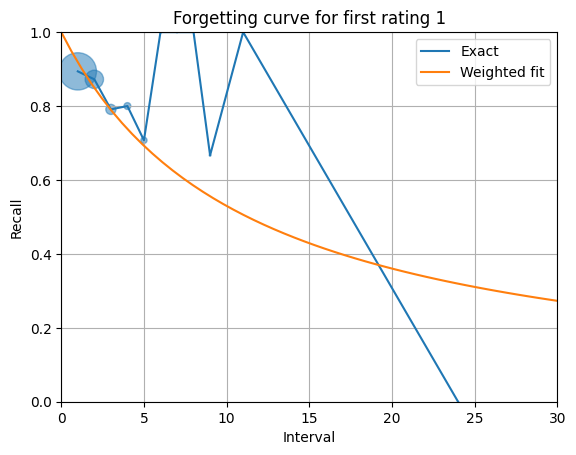

Weighted fit parameters: [1.71948624]
Number of reviews: 240
RMSE: 0.0599


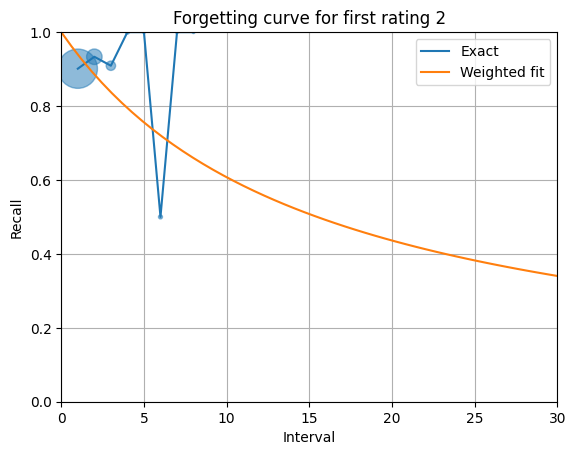

Weighted fit parameters: [8.75085746]
Number of reviews: 4669
RMSE: 0.0204


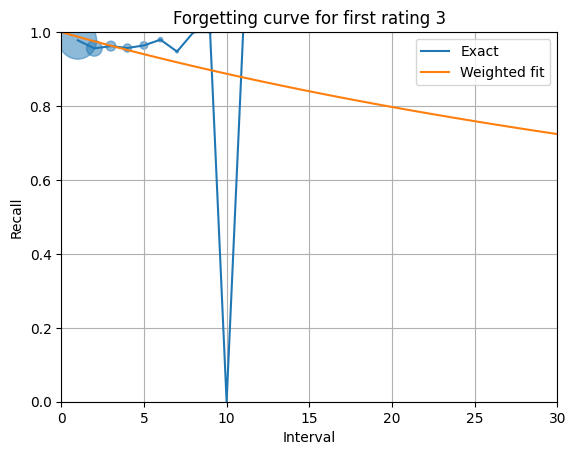

Weighted fit parameters: [16.52846133]
Number of reviews: 2789
RMSE: 0.0160


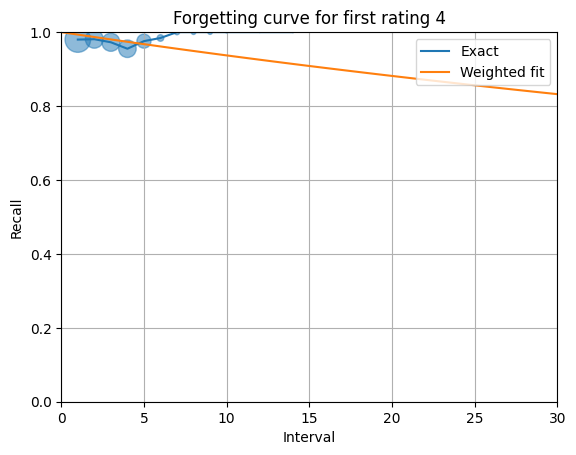

{1: 1.2516286139441613, 2: 1.7194862432507476, 3: 8.750857456400256, 4: 16.52846132731462}
Weighted fit parameters: [0.03758393 0.6949553  0.        ]
Fit stability: [ 2.08035641  4.1682427   8.35157242 16.73337346]
RMSE: 0.6171


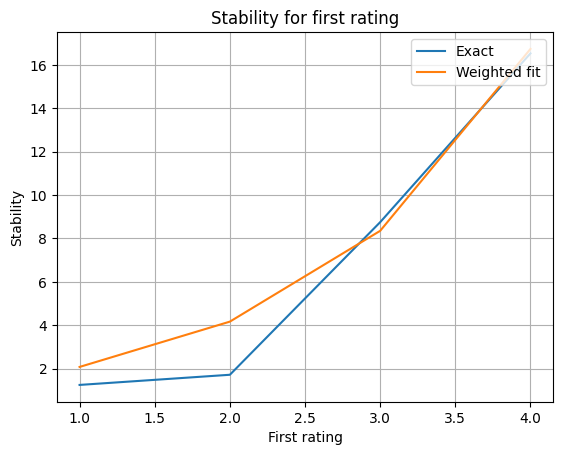

{1: 1.25, 2: 1.72, 3: 8.75, 4: 16.53}


In [4]:
from scipy.optimize import curve_fit

dataset = pd.read_csv("./revlog_history.tsv", sep='\t', index_col=None, dtype={'r_history': str ,'t_history': str} )
dataset = dataset[(dataset['i'] > 1) & (dataset['delta_t'] > 0) & (dataset['t_history'].str.count(',0') == 0)]
dataset['y'] = dataset['r'].map({1: 0, 2: 1, 3: 1, 4: 1})
S0_dataset = dataset[dataset['i'] == 2]
S0_dataset_group = S0_dataset.groupby(by=['r_history', 'delta_t'], group_keys=False).agg({'y': ['mean', 'count']}).reset_index()

# we want to find the optimal S
def power_curve(delta_t, S):
    return (1 + delta_t / (9 * S)) ** -1
# def exp_curve(delta_t, S):
#     return np.exp(np.log(0.9) * delta_t / S)

rating_stability = {}
rating_count = {}
reviews_in_collection = len(dataset)

for first_rating in ("1", "2", "3", "4"):
    group = S0_dataset_group[S0_dataset_group['r_history'] == first_rating]
    if group.empty:
        continue
    delta_t = group['delta_t']
    recall = group['y']['mean']
    count = group['y']['count']
    if sum(count) < 100:
        continue
    params, covs = curve_fit(power_curve, delta_t, recall, sigma=1/np.sqrt(count), bounds=((0.1), (3650)))
    rating_stability[int(first_rating)] = params[0]
    rating_count[int(first_rating)] = sum(count)
    print('Weighted fit parameters:', params)
    print('Number of reviews:', sum(count))
    predict_recall = power_curve(delta_t, *params)
    print(f'RMSE: {mean_squared_error(recall, predict_recall, sample_weight=count, squared=False):.4f}')

    plt.plot(delta_t, recall, label='Exact')
    plt.plot(np.linspace(0, 30), power_curve(np.linspace(0, 30), *params), label='Weighted fit')
    count_percent = np.array([x/sum(count) for x in count])
    plt.scatter(delta_t, recall, s=count_percent * 1000, alpha=0.5)
    plt.legend(loc='upper right', fancybox=True, shadow=False)
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xlim(0, 30)
    plt.xlabel('Interval')
    plt.ylabel('Recall')
    plt.title('Forgetting curve for first rating ' + first_rating)
    plt.show()

print(rating_stability)

def S0_rating_curve(rating, a, b, c):
    return np.exp(a + b * rating) + c

params, covs = curve_fit(S0_rating_curve, list(rating_stability.keys()), list(rating_stability.values()), sigma=1/np.sqrt(list(rating_count.values())), method='dogbox', bounds=((-15, 0.03, 0), (15, 7, 30)))
print('Weighted fit parameters:', params)
predict_stability = S0_rating_curve(np.array(list(rating_stability.keys())), *params)
print("Fit stability:", predict_stability)
print(f'RMSE: {mean_squared_error(list(rating_stability.values()), predict_stability, sample_weight=list(rating_count.values()), squared=False):.4f}')
plt.plot(list(rating_stability.keys()), list(rating_stability.values()), label='Exact')
plt.plot(list(rating_stability.keys()), predict_stability, label='Weighted fit')
plt.legend(loc='upper right', fancybox=True, shadow=False)
plt.grid(True)
plt.xlabel('First rating')
plt.ylabel('Stability')
plt.title('Stability for first rating')
plt.show()

for rating in (1, 2, 3, 4):
    again_extrap = max(min(S0_rating_curve(1, *params), 3650), 0.1)
    # if there isn't enough data to calculate the value for "Again" exactly
    if 1 not in rating_stability:
        # then check if there exists an exact value for "Hard"
        if 2 in rating_stability:
            # if it exists, then check whether the extrapolation breaks monotonicity
            # Again > Hard is possible, but we should allow it only for exact values, otherwise we should assume monotonicity
            if again_extrap > rating_stability[2]:
                # if it does, then replace the missing "Again" value with the exact "Hard" value
                rating_stability[1] = rating_stability[2]
            else:
                # if it doesn't break monotonicity, then use the extrapolated value
                rating_stability[1] = again_extrap
        # if an exact value for "Hard" doesn't exist, then just use the extrapolation, there's nothing else we can do
        else:
            rating_stability[1] = again_extrap
    elif rating not in rating_stability:
        rating_stability[rating] = max(min(S0_rating_curve(rating, *params), 3650), 0.1)

rating_stability = {k: round(v, 2) for k, v in sorted(rating_stability.items(), key=lambda item: item[0])}

print(rating_stability)

In [5]:
init_w = [1, 1, 5, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2, -0.2, 0.2, 1, 0.5, 2]

def power_forgetting_curve(t, s):
    return (1 + t / (9 * s)) ** -1

class FSRS(nn.Module):
    def __init__(self, w: List[float]):
        super(FSRS, self).__init__()
        self.w = nn.Parameter(torch.tensor(w, dtype=torch.float32))
        self.s0 = torch.zeros(4)
        for i in range(4):
            if i+1 in rating_stability:
                self.s0[i] = rating_stability[i+1]

    def stability_after_success(self, state: Tensor, new_d: Tensor, r: Tensor, rating: Tensor) -> Tensor:
        hard_bonus = torch.where(rating == 2, self.w[13], 1)
        easy_bonus = torch.where(rating == 4, self.w[14], 1)
        new_s = state[:,0] * (1 + torch.exp(self.w[6]) *
                        (11 - new_d) *
                        torch.pow(state[:,0], self.w[7]) *
                        (torch.exp((1 - r) * self.w[8]) - 1) * hard_bonus * easy_bonus)
        return new_s

    def stability_after_failure(self, state: Tensor, new_d: Tensor, r: Tensor) -> Tensor:
        new_s = self.w[9] * \
                torch.pow(new_d, self.w[10]) * \
                (torch.pow(state[:,0] + 1, self.w[11]) - 1) * \
                torch.exp((1 - r) * self.w[12])
        return new_s

    def step(self, X: Tensor, state: Tensor) -> Tensor:
        '''
        :param X: shape[batch_size, 2], X[:,0] is elapsed time, X[:,1] is rating
        :param state: shape[batch_size, 2], state[:,0] is stability, state[:,1] is difficulty
        :return state:
        '''
        if torch.equal(state, torch.zeros_like(state)):
            keys = torch.tensor([1, 2, 3, 4])
            keys = keys.view(1, -1).expand(X[:,1].long().size(0), -1)
            index = (X[:,1].long().unsqueeze(1) == keys).nonzero(as_tuple=True)
            # first learn, init memory states
            new_s = self.s0[index[1]]
            new_d = self.w[2] + self.w[3] * (X[:,1] - 3)
            new_d = new_d.clamp(1, 10)
        else:
            r = power_forgetting_curve(X[:,0], state[:,0])
            new_d = state[:,1] + self.w[4] * (X[:,1] - 3)
            new_d = self.mean_reversion(self.w[2], new_d)
            new_d = new_d.clamp(1, 10)
            condition = X[:,1] > 1
            new_s = torch.where(condition, self.stability_after_success(state, new_d, r, X[:,1]), self.stability_after_failure(state, new_d, r))
        new_s = new_s.clamp(0.1, 36500)
        return torch.stack([new_s, new_d], dim=1)

    def forward(self, inputs: Tensor, state: Optional[Tensor]=None) -> Tensor:
        '''
        :param inputs: shape[seq_len, batch_size, 2]
        '''
        if state is None:
            state = torch.zeros((inputs.shape[1], 2))
        outputs = []
        for X in inputs:
            state = self.step(X, state)
            outputs.append(state)
        return torch.stack(outputs), state

    def mean_reversion(self, init: Tensor, current: Tensor) -> Tensor:
        return self.w[5] * init + (1-self.w[5]) * current

class WeightClipper:
    def __init__(self, frequency: int=1):
        self.frequency = frequency

    def __call__(self, module):
        if hasattr(module, 'w'):
            w = module.w.data
            w[0] = w[0].clamp(0.1, 10)
            w[1] = w[1].clamp(0.1, 5)
            w[2] = w[2].clamp(1, 10)
            w[3] = w[3].clamp(-5, -0.1)
            w[4] = w[4].clamp(-5, -0.1)
            w[5] = w[5].clamp(0, 0.5)
            w[6] = w[6].clamp(0, 2)
            w[7] = w[7].clamp(-0.8, -0.1)
            w[8] = w[8].clamp(0.01, 1.5)
            w[9] = w[9].clamp(0.5, 5)
            w[10] = w[10].clamp(-2, -0.01)
            w[11] = w[11].clamp(0.01, 0.9)
            w[12] = w[12].clamp(0.01, 2)
            w[13] = w[13].clamp(0, 1)
            w[14] = w[14].clamp(1, 10)
            module.w.data = w

def lineToTensor(line: str) -> Tensor:
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 2)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
    return tensor

class RevlogDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        if dataframe.empty:
            raise ValueError('Training data is inadequate.')
        padded = pad_sequence(dataframe['tensor'].to_list(), batch_first=True, padding_value=0)
        self.x_train = padded.int()
        self.t_train = torch.tensor(dataframe['delta_t'].values, dtype=torch.int)
        self.y_train = torch.tensor(dataframe['y'].values, dtype=torch.float)
        self.seq_len = torch.tensor(dataframe['tensor'].map(len).values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.x_train[idx], self.t_train[idx], self.y_train[idx], self.seq_len[idx]

    def __len__(self):
        return len(self.y_train)

class RevlogSampler(Sampler[List[int]]):
    def __init__(self, data_source: RevlogDataset, batch_size: int):
        self.data_source = data_source
        self.batch_size = batch_size
        lengths = np.array(data_source.seq_len)
        indices = np.argsort(lengths)
        full_batches, remainder = divmod(indices.size, self.batch_size)
        if full_batches > 0:
            if remainder == 0:
                self.batch_indices = np.split(indices, full_batches)
            else:
                self.batch_indices = np.split(indices[:-remainder], full_batches)
        else:
            self.batch_indices = []
        if remainder > 0:
            self.batch_indices.append(indices[-remainder:])
        self.batch_nums = len(self.batch_indices)
        # seed = int(torch.empty((), dtype=torch.int64).random_().item())
        seed = 2023
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def __iter__(self):
        yield from (self.batch_indices[idx] for idx in torch.randperm(self.batch_nums, generator=self.generator).tolist())

    def __len__(self):
        return len(self.data_source)


def collate_fn(batch):
    sequences, delta_ts, labels, seq_lens = zip(*batch)
    sequences_packed = pack_padded_sequence(torch.stack(sequences, dim=1), lengths=torch.stack(seq_lens), batch_first=False, enforce_sorted=False)
    sequences_padded, length = pad_packed_sequence(sequences_packed, batch_first=False)
    sequences_padded = torch.as_tensor(sequences_padded)
    seq_lens = torch.as_tensor(length)
    delta_ts = torch.as_tensor(delta_ts)
    labels = torch.as_tensor(labels)
    return sequences_padded, delta_ts, labels, seq_lens

class Trainer:
    def __init__(self, train_set: pd.DataFrame, test_set: pd.DataFrame, init_w: List[float], n_epoch: int=1, lr: float=1e-2, batch_size: int=256) -> None:
        self.model = FSRS(init_w)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.clipper = WeightClipper()
        self.batch_size = batch_size
        self.build_dataset(train_set, test_set)
        self.n_epoch = n_epoch
        self.batch_nums = self.next_train_data_loader.batch_sampler.batch_nums
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.batch_nums * n_epoch)
        self.avg_train_losses = []
        self.avg_eval_losses = []
        self.loss_fn = nn.BCELoss(reduction='none')

    def build_dataset(self, train_set: pd.DataFrame, test_set: pd.DataFrame):
        pre_train_set = train_set[train_set['i'] == 2]
        self.pre_train_set = RevlogDataset(pre_train_set)
        sampler = RevlogSampler(self.pre_train_set, batch_size=self.batch_size)
        self.pre_train_data_loader = DataLoader(self.pre_train_set, batch_sampler=sampler, collate_fn=collate_fn)

        next_train_set = train_set[train_set['i'] > 2]
        self.next_train_set = RevlogDataset(next_train_set)
        sampler = RevlogSampler(self.next_train_set, batch_size=self.batch_size)
        self.next_train_data_loader = DataLoader(self.next_train_set, batch_sampler=sampler, collate_fn=collate_fn)

        self.train_set = RevlogDataset(train_set)
        sampler = RevlogSampler(self.train_set, batch_size=self.batch_size)
        self.train_data_loader = DataLoader(self.train_set, batch_sampler=sampler, collate_fn=collate_fn)

        self.test_set = RevlogDataset(test_set)
        sampler = RevlogSampler(self.test_set, batch_size=self.batch_size)
        self.test_data_loader = DataLoader(self.test_set, batch_sampler=sampler, collate_fn=collate_fn)
        print("dataset built")

    def train(self, verbose: bool=True):
        best_loss = np.inf

        epoch_len = len(self.next_train_data_loader)
        pbar = tqdm(desc="train", colour="red", total=epoch_len*self.n_epoch)
        print_len = max(self.batch_nums*self.n_epoch // 10, 1)
        for k in range(self.n_epoch):
            weighted_loss, w = self.eval()
            if weighted_loss < best_loss:
                best_loss = weighted_loss
                best_w = w

            for i, batch in enumerate(self.next_train_data_loader):
                self.model.train()
                self.optimizer.zero_grad()
                sequences, delta_ts, labels, seq_lens = batch
                real_batch_size = seq_lens.shape[0]
                outputs, _ = self.model(sequences)
                stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
                retentions = power_forgetting_curve(delta_ts, stabilities)
                loss = self.loss_fn(retentions, labels).sum()
                loss.backward()
                for param in self.model.parameters():
                    param.grad[:2] = torch.zeros(2)
                self.optimizer.step()
                self.scheduler.step()
                self.model.apply(self.clipper)
                pbar.update(real_batch_size)

                if verbose and (k * self.batch_nums + i + 1) % print_len == 0:
                    tqdm.write(f"iteration: {k * epoch_len + (i + 1) * self.batch_size}")
                    for name, param in self.model.named_parameters():
                        tqdm.write(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")
        pbar.close()

        weighted_loss, w = self.eval()
        if weighted_loss < best_loss:
            best_loss = weighted_loss
            best_w = w

        return best_w

    def eval(self):
        self.model.eval()
        with torch.no_grad():
            sequences, delta_ts, labels, seq_lens = self.train_set.x_train, self.train_set.t_train, self.train_set.y_train, self.train_set.seq_len
            real_batch_size = seq_lens.shape[0]
            outputs, _ = self.model(sequences.transpose(0, 1))
            stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
            retentions = power_forgetting_curve(delta_ts, stabilities)
            tran_loss = self.loss_fn(retentions, labels).mean()
            self.avg_train_losses.append(tran_loss)
            tqdm.write(f"Loss in trainset: {tran_loss:.4f}")

            sequences, delta_ts, labels, seq_lens = self.test_set.x_train, self.test_set.t_train, self.test_set.y_train, self.test_set.seq_len
            real_batch_size = seq_lens.shape[0]
            outputs, _ = self.model(sequences.transpose(0, 1))
            stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
            retentions = power_forgetting_curve(delta_ts, stabilities)
            test_loss = self.loss_fn(retentions, labels).mean()
            self.avg_eval_losses.append(test_loss)
            tqdm.write(f"Loss in testset: {test_loss:.4f}")

            w = list(map(lambda x: round(float(x), 4), dict(self.model.named_parameters())['w'].data))

            weighted_loss = (tran_loss * len(self.train_set) + test_loss * len(self.test_set)) / (len(self.train_set) + len(self.test_set))

            return weighted_loss, w

    def plot(self):
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(self.avg_train_losses, label='train')
        ax.plot(self.avg_eval_losses, label='test')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
        return fig

  0%|          | 0/88151 [00:00<?, ?it/s]

Tensorized!
TRAIN: 68161 TEST: 19990
dataset built


train:   0%|          | 0/315345 [00:00<?, ?it/s]

Loss in trainset: 0.3315
Loss in testset: 0.2918
iteration: 31744
w: [1.0, 1.0, 5.333, -1.2957, -0.9652, 0.0337, 1.3747, -0.1, 0.7983, 2.2572, -0.01, 0.401, 0.9117, 0.0, 2.3836]
iteration: 63488
w: [1.0, 1.0, 5.3911, -1.0726, -1.1071, 0.0249, 1.4648, -0.2029, 0.8876, 2.3683, -0.01, 0.3573, 0.746, 0.0, 2.471]
Loss in trainset: 0.3132
Loss in testset: 0.2761
iteration: 94813
w: [1.0, 1.0, 5.477, -1.262, -1.084, 0.0268, 1.4611, -0.1343, 0.8847, 2.4763, -0.0189, 0.373, 0.5431, 0.0, 2.2787]
iteration: 126557
w: [1.0, 1.0, 5.5136, -1.2882, -1.0495, 0.0158, 1.4921, -0.1373, 0.9124, 2.5461, -0.01, 0.3346, 0.4526, 0.0, 2.1692]
Loss in trainset: 0.3127
Loss in testset: 0.2759
iteration: 157882
w: [1.0, 1.0, 5.588, -1.2592, -1.0227, 0.0001, 1.4577, -0.2017, 0.879, 2.6363, -0.01, 0.3741, 0.3991, 0.0, 2.105]
iteration: 189626
w: [1.0, 1.0, 5.6845, -1.396, -1.1133, 0.0086, 1.5235, -0.1134, 0.9358, 2.6671, -0.0101, 0.3461, 0.2656, 0.0, 2.0913]
Loss in trainset: 0.3127
Loss in testset: 0.2761
iteratio

train:   0%|          | 0/307645 [00:00<?, ?it/s]

Loss in trainset: 0.3204
Loss in testset: 0.3316
iteration: 30720
w: [1.0, 1.0, 5.1608, -1.1209, -0.9761, 0.038, 1.4602, -0.1965, 0.8792, 2.1984, -0.0898, 0.349, 0.9714, 0.0, 2.1287]
iteration: 61440
w: [1.0, 1.0, 5.2676, -1.2256, -1.0056, 0.0, 1.434, -0.1971, 0.8608, 2.247, -0.0476, 0.3008, 0.8708, 0.0, 2.0557]
Loss in trainset: 0.3056
Loss in testset: 0.3145
iteration: 91737
w: [1.0, 1.0, 5.2424, -1.0884, -1.0832, 0.0, 1.5142, -0.1915, 0.9464, 2.3584, -0.0394, 0.3323, 0.8275, 0.0, 2.2688]
iteration: 122457
w: [1.0, 1.0, 5.4612, -1.4426, -1.0114, 0.0678, 1.4428, -0.2121, 0.8786, 2.4639, -0.0175, 0.3523, 0.8109, 0.0, 1.9707]
Loss in trainset: 0.3039
Loss in testset: 0.3124
iteration: 152754
w: [1.0, 1.0, 5.4627, -1.4358, -1.0655, 0.0043, 1.508, -0.1505, 0.9369, 2.4956, -0.029, 0.3106, 0.679, 0.0, 1.9269]
iteration: 183474
w: [1.0, 1.0, 5.4767, -1.407, -1.0641, 0.008, 1.5076, -0.1677, 0.9403, 2.5598, -0.01, 0.3239, 0.6493, 0.0, 1.7894]
Loss in trainset: 0.3026
Loss in testset: 0.3113
it

train:   0%|          | 0/315215 [00:00<?, ?it/s]

Loss in trainset: 0.3273
Loss in testset: 0.3042
iteration: 31744
w: [1.0, 1.0, 5.1514, -1.0565, -0.8234, 0.0163, 1.386, -0.1235, 0.8209, 2.2881, -0.01, 0.3914, 1.1153, 0.0, 2.6078]
iteration: 63488
w: [1.0, 1.0, 5.366, -1.3647, -0.963, 0.037, 1.3736, -0.1353, 0.8146, 2.3499, -0.01, 0.3448, 0.939, 0.0, 2.3096]
Loss in trainset: 0.3091
Loss in testset: 0.2881
iteration: 94787
w: [1.0, 1.0, 5.3641, -1.2601, -0.9812, 0.0929, 1.4388, -0.1504, 0.8655, 2.4591, -0.012, 0.3193, 0.7796, 0.0, 2.4518]
iteration: 126531
w: [1.0, 1.0, 5.4727, -1.3992, -1.0349, 0.0255, 1.4362, -0.1965, 0.8671, 2.5738, -0.01, 0.3692, 0.8347, 0.0, 2.3345]
Loss in trainset: 0.3096
Loss in testset: 0.2889
iteration: 157830
w: [1.0, 1.0, 5.3461, -1.1458, -0.9918, 0.0073, 1.4882, -0.162, 0.9148, 2.5853, -0.0314, 0.3275, 0.7309, 0.0, 2.1148]
iteration: 189574
w: [1.0, 1.0, 5.4344, -1.224, -1.0017, 0.025, 1.474, -0.1645, 0.8982, 2.6416, -0.01, 0.3184, 0.6935, 0.0, 2.1144]
Loss in trainset: 0.3088
Loss in testset: 0.2878
ite

train:   0%|          | 0/315040 [00:00<?, ?it/s]

Loss in trainset: 0.3179
Loss in testset: 0.3413
iteration: 31744
w: [1.0, 1.0, 5.242, -1.1342, -0.8711, 0.0091, 1.3238, -0.1056, 0.7702, 2.2099, -0.1098, 0.3991, 0.9472, 0.0, 2.3897]
iteration: 63488
w: [1.0, 1.0, 5.2944, -1.2384, -0.8897, 0.0448, 1.3947, -0.1334, 0.8392, 2.2485, -0.0357, 0.2773, 0.8075, 0.0, 2.5481]
Loss in trainset: 0.3012
Loss in testset: 0.3248
iteration: 94752
w: [1.0, 1.0, 5.4136, -1.2061, -1.0709, 0.055, 1.4475, -0.1424, 0.8778, 2.4147, -0.0104, 0.3266, 0.7482, 0.0, 2.4529]
iteration: 126496
w: [1.0, 1.0, 5.4841, -1.3556, -1.0853, 0.0, 1.4757, -0.1025, 0.9075, 2.5068, -0.0208, 0.3399, 0.7831, 0.0, 2.4841]
Loss in trainset: 0.2998
Loss in testset: 0.3229
iteration: 157760
w: [1.0, 1.0, 5.4333, -1.2545, -1.0314, 0.0, 1.4577, -0.1134, 0.8875, 2.556, -0.0153, 0.3393, 0.5758, 0.0, 2.5176]
iteration: 189504
w: [1.0, 1.0, 5.4809, -1.235, -1.0414, 0.0322, 1.4853, -0.1387, 0.9158, 2.5979, -0.01, 0.327, 0.593, 0.0, 2.3503]
Loss in trainset: 0.3004
Loss in testset: 0.3235

train:   0%|          | 0/314555 [00:00<?, ?it/s]

Loss in trainset: 0.3161
Loss in testset: 0.3522
iteration: 31232
w: [1.0, 1.0, 5.211, -1.3146, -0.8666, 0.056, 1.3733, -0.1498, 0.7916, 2.2756, -0.01, 0.3849, 0.9704, 0.0, 2.8045]
iteration: 62464
w: [1.0, 1.0, 5.2741, -1.2837, -1.0341, 0.0066, 1.3731, -0.1745, 0.8032, 2.4026, -0.0551, 0.3426, 0.8848, 0.0, 2.5191]
Loss in trainset: 0.2995
Loss in testset: 0.3329
iteration: 93631
w: [1.0, 1.0, 5.2331, -1.2301, -0.9635, 0.0217, 1.4304, -0.1, 0.8671, 2.5658, -0.01, 0.3499, 0.6983, 0.0, 2.1038]
iteration: 124863
w: [1.0, 1.0, 5.4649, -1.501, -1.1097, 0.0218, 1.4275, -0.1512, 0.8659, 2.6333, -0.01, 0.3353, 0.6016, 0.0, 2.4961]
Loss in trainset: 0.2987
Loss in testset: 0.3332
iteration: 156030
w: [1.0, 1.0, 5.4757, -1.4649, -1.1114, 0.0, 1.4445, -0.159, 0.8792, 2.7126, -0.01, 0.3214, 0.4887, 0.0, 2.3981]
iteration: 187262
w: [1.0, 1.0, 5.4729, -1.4157, -1.056, 0.0004, 1.4344, -0.161, 0.8736, 2.7641, -0.0112, 0.3151, 0.4231, 0.0, 2.4404]
Loss in trainset: 0.2991
Loss in testset: 0.3328
itera

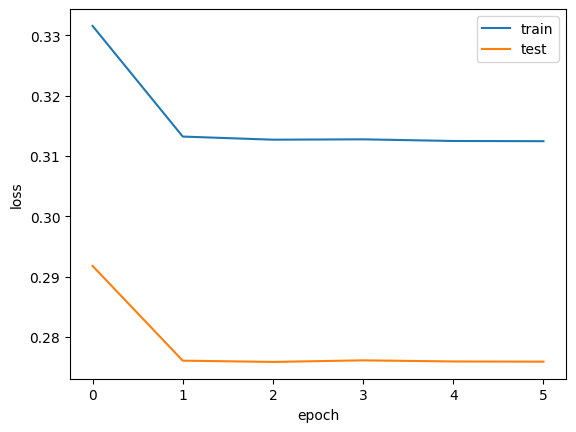

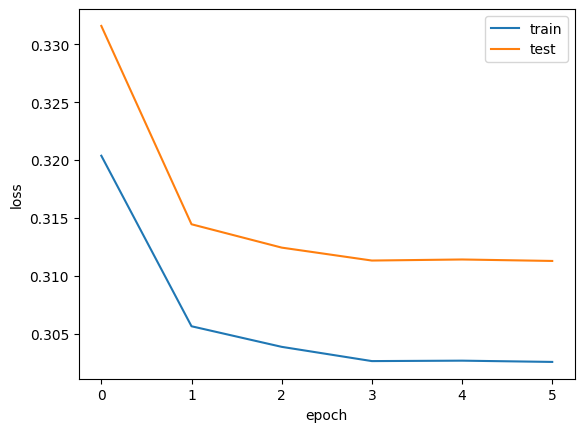

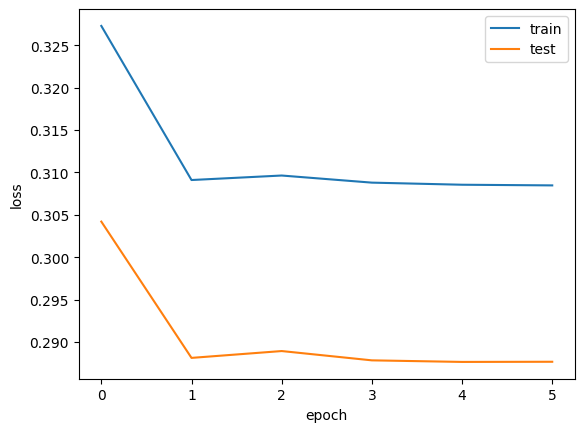

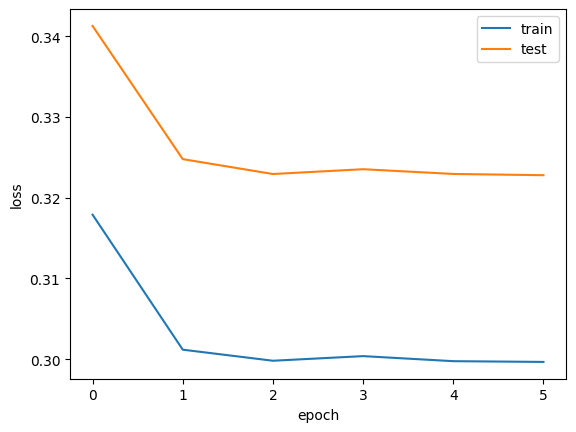

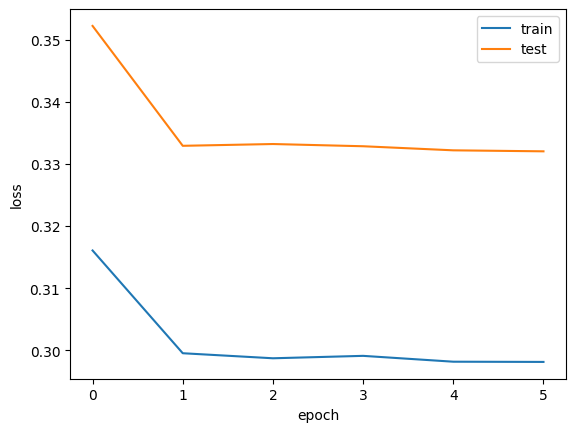

In [6]:
lr: float = 4e-2
n_epoch: int = 5
n_splits: int = 5
batch_size: int = 512
verbose: bool = True

dataset = pd.read_csv("./revlog_history.tsv", sep='\t', index_col=None, dtype={'r_history': str ,'t_history': str} )
dataset = dataset[(dataset['i'] > 1) & (dataset['delta_t'] > 0) & (dataset['t_history'].str.count(',0') == 0)]
if dataset.empty:
    raise ValueError('Training data is inadequate.')
dataset['tensor'] = dataset.progress_apply(lambda x: lineToTensor(list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
dataset['group'] = dataset['r_history'] + dataset['t_history']
print("Tensorized!")

w = []
plots = []
if n_splits > 1:
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    for train_index, test_index in sgkf.split(dataset, dataset['i'], dataset['group']):
        print("TRAIN:", len(train_index), "TEST:",  len(test_index))
        train_set = dataset.iloc[train_index].copy()
        test_set = dataset.iloc[test_index].copy()
        trainer = Trainer(train_set, test_set, init_w, n_epoch=n_epoch, lr=lr, batch_size=batch_size)
        w.append(trainer.train(verbose=verbose))
        plots.append(trainer.plot())
else:
    trainer = Trainer(dataset, dataset, init_w, n_epoch=n_epoch, lr=lr, batch_size=batch_size)
    w.append(trainer.train(verbose=verbose))
    plots.append(trainer.plot())

w = np.array(w)
avg_w = np.round(np.mean(w, axis=0), 4)
w = avg_w.tolist()
print("\nTraining finished!")

In [7]:
print(w)

class Collection:
    def __init__(self, w: List[float]) -> None:
        self.model = FSRS(w)
        self.model.eval()

    def predict(self, t_history: str, r_history: str):
        with torch.no_grad():
            line_tensor = lineToTensor(list(zip([t_history], [r_history]))[0]).unsqueeze(1)
            output_t = self.model(line_tensor)
            return output_t[-1][0]

    def batch_predict(self, dataset):
        fast_dataset = RevlogDataset(dataset)
        with torch.no_grad():
            outputs, _ = self.model(fast_dataset.x_train.transpose(0, 1))
            stabilities, difficulties = outputs[fast_dataset.seq_len-1, torch.arange(len(fast_dataset))].transpose(0, 1)
            return stabilities.tolist(), difficulties.tolist()
        
requestRetention = 0.9

my_collection = Collection(w)
preview_text = "1:again, 2:hard, 3:good, 4:easy\n"
for first_rating in (1,2,3,4):
    preview_text += f'\nfirst rating: {first_rating}\n'
    t_history = "0"
    d_history = "0"
    r_history = f"{first_rating}"  # the first rating of the new card
    # print("stability, difficulty, lapses")
    for i in range(10):
        states = my_collection.predict(t_history, r_history)
        # print('{0:9.2f} {1:11.2f} {2:7.0f}'.format(
            # *list(map(lambda x: round(float(x), 4), states))))
        next_t = max(1, round(float(9 * states[0] * (1/requestRetention - 1))))
        difficulty = round(float(states[1]), 1)
        t_history += f',{int(next_t)}'
        d_history += f',{difficulty}'
        r_history += f",3"
    preview_text += f"rating history: {r_history}\n"
    preview_text += "interval history: " + ",".join([f"{ivl}d" if ivl < 30 else f"{ivl / 30:.1f}m" if ivl < 365 else f"{ivl / 365:.1f}y" for ivl in map(int, t_history.split(','))]) + "\n"
    preview_text += f"difficulty history: {d_history}\n"
print(preview_text)

[1.0, 1.0, 5.5421, -1.328, -1.0607, 0.0071, 1.4926, -0.1339, 0.9146, 2.7059, -0.0118, 0.3176, 0.4738, 0.0, 2.1384]
1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0d,1d,2d,5d,10d,19d,1.1m,2.0m,3.5m,5.8m,9.5m
difficulty history: 0,8.2,8.2,8.2,8.1,8.1,8.1,8.1,8.1,8.1,8.0

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0d,2d,5d,12d,27d,1.9m,3.9m,7.6m,1.2y,2.1y,3.6y
difficulty history: 0,6.9,6.9,6.9,6.8,6.8,6.8,6.8,6.8,6.8,6.8

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0d,9d,24d,2.0m,4.8m,10.5m,1.8y,3.5y,6.7y,12.1y,21.3y
difficulty history: 0,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0d,17d,1.7m,4.5m,11.3m,2.1y,4.7y,9.6y,18.9y,35.4y,63.8y
difficulty history: 0,4.2,4.2,4.2,4.2,4.3,4.3,4.3,4.3,4.3,4.3



In [8]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9

t_history = "0"
d_history = "0"
for i in range(len(test_rating_sequence.split(','))):
    rating = test_rating_sequence[2*i]
    last_t = int(t_history.split(',')[-1])
    r_history = test_rating_sequence[:2*i+1]
    states = my_collection.predict(t_history, r_history)
    print(states)
    next_t = max(1, round(float(9 * states[0] * (1/requestRetention - 1))))
    t_history += f',{int(next_t)}'
    difficulty = round(float(states[1]), 1)
    d_history += f',{difficulty}'
preview_text = f"rating history: {test_rating_sequence}\n"
preview_text += f"interval history: {t_history}\n"
preview_text += f"difficulty history: {d_history}"
print(preview_text)

tensor([8.7500, 5.5421])
tensor([24.3772,  5.5421])
tensor([60.8007,  5.5421])
tensor([142.6242,   5.5421])
tensor([313.7513,   5.5421])
tensor([14.4420,  7.6484])
tensor([3.8210, 9.7398])
tensor([5.6533, 9.7100])
tensor([8.3187, 9.6804])
tensor([11.7887,  9.6510])
tensor([16.8472,  9.6219])
tensor([23.8260,  9.5929])
rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0,9,24,61,143,314,14,4,6,8,12,17,24
difficulty history: 0,5.5,5.5,5.5,5.5,5.5,7.6,9.7,9.7,9.7,9.7,9.6,9.6


In [9]:
my_collection = Collection(init_w)
stabilities, difficulties = my_collection.batch_predict(dataset)
dataset['stability'] = stabilities
dataset['difficulty'] = difficulties
dataset['p'] = power_forgetting_curve(dataset['delta_t'], dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
loss_before = dataset['log_loss'].mean()

my_collection = Collection(w)
stabilities, difficulties = my_collection.batch_predict(dataset)
dataset['stability'] = stabilities
dataset['difficulty'] = difficulties
dataset['p'] = power_forgetting_curve(dataset['delta_t'], dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
loss_after = dataset['log_loss'].mean()

tmp = dataset.copy()
tmp['stability'] = tmp['stability'].map(lambda x: round(x, 2))
tmp['difficulty'] = tmp['difficulty'].map(lambda x: round(x, 2))
tmp['p'] = tmp['p'].map(lambda x: round(x, 2))
tmp['log_loss'] = tmp['log_loss'].map(lambda x: round(x, 2))
tmp.rename(columns={"r": "grade", "p": "retrievability"}, inplace=True)
tmp[['id', 'cid', 'review_date', 'r_history', 't_history', 'delta_t', 'grade', 'stability', 'difficulty', 'retrievability', 'log_loss']].to_csv("./evaluation.tsv", sep='\t', index=False)
del tmp
print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}, improvement: {loss_before - loss_after:.4f}")

loss before: 0.3225, loss after: 0.3042, improvement: 0.0183


R-squared: 0.9662
RMSE: 0.0141
[0.05504343 0.93827808]


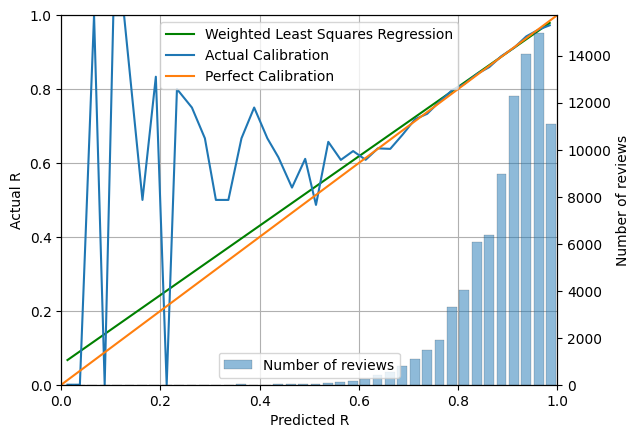


Last rating: 1
R-squared: 0.4438
RMSE: 0.0400
[0.29091542 0.65889318]

Last rating: 2
R-squared: 0.5924
RMSE: 0.0532
[0.04836937 0.89537378]

Last rating: 3
R-squared: 0.9585
RMSE: 0.0163
[0.0307962  0.97317658]

Last rating: 4
R-squared: 0.7365
RMSE: 0.0177
[0.10787815 0.88406149]


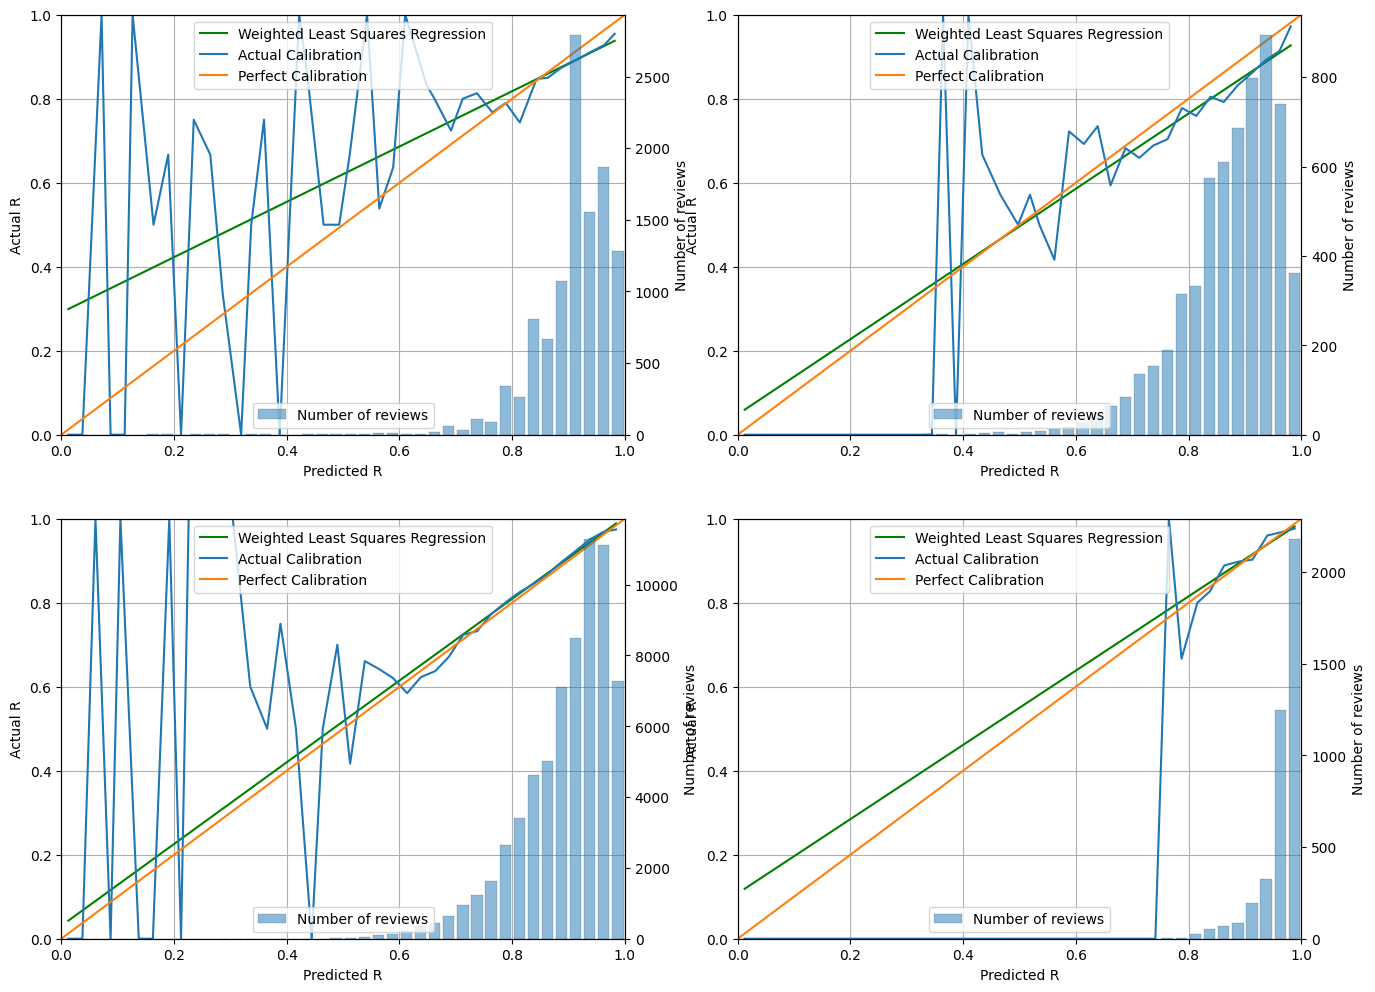

In [10]:
# code from https://github.com/papousek/duolingo-halflife-regression/blob/master/evaluation.py
def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)
    for p, r in zip(predictions, real):
        bin = min(int(p * bins), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    np.seterr(invalid='ignore')
    prediction_means = prediction / counts
    prediction_means[np.isnan(prediction_means)] = ((np.arange(bins) + 0.5) / bins)[np.isnan(prediction_means)]
    correct_means = correct / counts
    correct_means[np.isnan(correct_means)] = 0
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": list(counts),
            "bin_prediction_means": list(prediction_means),
            "bin_correct_means": list(correct_means),
        }
    }


def plot_brier(predictions, real, bins=20):
    brier = load_brier(predictions, real, bins=bins)
    bin_prediction_means = brier['detail']['bin_prediction_means']
    bin_correct_means = brier['detail']['bin_correct_means']
    bin_counts = brier['detail']['bin_counts']
    r2 = r2_score(bin_correct_means, bin_prediction_means, sample_weight=bin_counts)
    rmse = mean_squared_error(bin_correct_means, bin_prediction_means, sample_weight=bin_counts, squared=False)
    print(f"R-squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.grid(True)
    fit_wls = sm.WLS(bin_correct_means, sm.add_constant(bin_prediction_means), weights=bin_counts).fit()
    print(fit_wls.params)
    y_regression = [fit_wls.params[0] + fit_wls.params[1]*x for x in bin_prediction_means]
    plt.plot(bin_prediction_means, y_regression, label='Weighted Least Squares Regression', color="green")
    plt.plot(bin_prediction_means, bin_correct_means, label='Actual Calibration', color="#1f77b4")
    plt.plot((0, 1), (0, 1), label='Perfect Calibration', color="#ff7f0e")
    bin_count = brier['detail']['bin_count']
    counts = np.array(bin_counts)
    bins = (np.arange(bin_count) + 0.5) / bin_count
    plt.legend(loc='upper center')
    plt.xlabel('Predicted R')
    plt.ylabel('Actual R')
    plt.twinx()
    plt.ylabel('Number of reviews')
    plt.bar(bins, counts, width=(0.8 / bin_count), ec='k', lw=.2, alpha=0.5, label='Number of reviews')
    plt.legend(loc='lower center')


plot_brier(dataset['p'], dataset['y'], bins=40)
plt.show()
plt.figure(figsize=(16, 12))
for last_rating in ("1","2","3","4"):
    plt.subplot(2, 2, int(last_rating))
    print(f"\nLast rating: {last_rating}")
    plot_brier(dataset[dataset['r_history'].str.endswith(last_rating)]['p'], dataset[dataset['r_history'].str.endswith(last_rating)]['y'], bins=40)

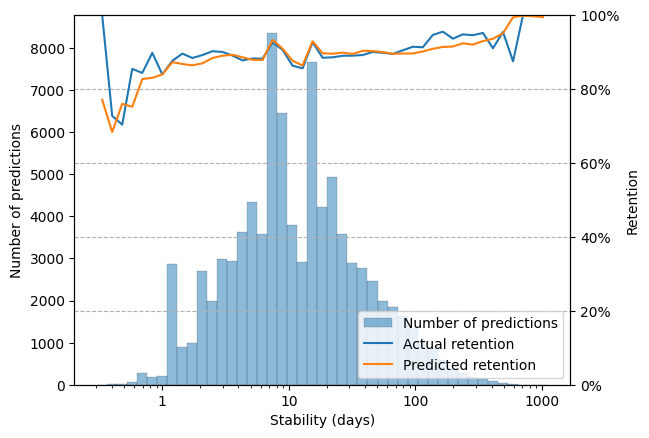

In [11]:
def to_percent(temp, position):
    return '%1.0f' % (100 * temp) + '%'

fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = []

stability_calibration = pd.DataFrame(columns=['stability', 'predicted_retention', 'actual_retention'])
stability_calibration = dataset[['stability', 'p', 'y']].copy()
stability_calibration['bin'] = stability_calibration['stability'].map(lambda x: math.pow(1.2, math.floor(math.log(x, 1.2))))
stability_group = stability_calibration.groupby('bin').count()

lns1 = ax1.bar(x=stability_group.index, height=stability_group['y'], width=stability_group.index / 5.5,
                ec='k', lw=.2, label='Number of predictions', alpha=0.5)
ax1.set_ylabel("Number of predictions")
ax1.set_xlabel("Stability (days)")
ax1.semilogx()
lns.append(lns1)

stability_group = stability_calibration.groupby(by='bin').agg('mean')
lns2 = ax2.plot(stability_group['y'], label='Actual retention')
lns3 = ax2.plot(stability_group['p'], label='Predicted retention')
ax2.set_ylabel("Retention")
ax2.set_ylim(0, 1)
lns.append(lns2[0])
lns.append(lns3[0])

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right')
plt.grid(linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

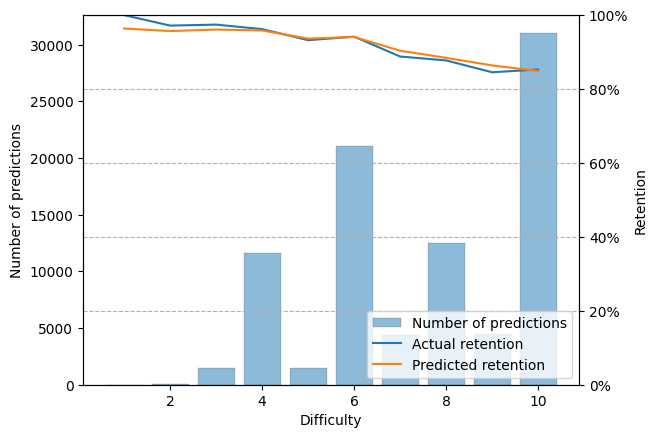

In [12]:
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = []

difficulty_calibration = pd.DataFrame(columns=['difficulty', 'predicted_retention', 'actual_retention'])
difficulty_calibration = dataset[['difficulty', 'p', 'y']].copy()
difficulty_calibration['bin'] = difficulty_calibration['difficulty'].map(round)
difficulty_group = difficulty_calibration.groupby('bin').count()

lns1 = ax1.bar(x=difficulty_group.index, height=difficulty_group['y'],
                ec='k', lw=.2, label='Number of predictions', alpha=0.5)
ax1.set_ylabel("Number of predictions")
ax1.set_xlabel("Difficulty")
lns.append(lns1)

difficulty_group = difficulty_calibration.groupby(by='bin').agg('mean')
lns2 = ax2.plot(difficulty_group['y'], label='Actual retention')
lns3 = ax2.plot(difficulty_group['p'], label='Predicted retention')
ax2.set_ylabel("Retention")
ax2.set_ylim(0, 1)
lns.append(lns2[0])
lns.append(lns3[0])

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right')
plt.grid(linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

In [13]:
B_W_Metric_raw = dataset[['difficulty', 'stability', 'p', 'y']].copy()
B_W_Metric_raw['s_bin'] = B_W_Metric_raw['stability'].map(lambda x: round(math.pow(1.4, math.floor(math.log(x, 1.4))), 2))
B_W_Metric_raw['d_bin'] = B_W_Metric_raw['difficulty'].map(lambda x: int(round(x)))
B_W_Metric = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin']).agg('mean').reset_index()
B_W_Metric_count = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin']).agg('count').reset_index()
B_W_Metric['B-W'] = B_W_Metric['p'] - B_W_Metric['y']
n = len(dataset)
bins = len(B_W_Metric)
B_W_Metric_pivot = B_W_Metric[B_W_Metric_count['p'] > max(50, n / (3 * bins))].pivot(index="s_bin", columns='d_bin', values='B-W')
B_W_Metric_pivot.apply(pd.to_numeric).style.background_gradient(cmap='seismic', axis=None, vmin=-0.2, vmax=0.2).format("{:.2%}", na_rep='')

d_bin,3,4,5,6,7,8,9,10
s_bin,,,,,,,,
0.710000,,,,,,,,-3.42%
1.000000,,,,,,0.99%,,-3.00%
1.400000,,,,,1.78%,,,-3.69%
1.960000,,,,,,-4.24%,,-1.58%
2.740000,,,,,,1.28%,,-1.27%
3.840000,,,,,,-0.64%,3.39%,0.62%
5.380000,,,,-0.80%,,-0.86%,2.15%,-0.68%
7.530000,,,,0.71%,1.51%,1.33%,4.08%,0.17%
10.540000,,,,-0.68%,2.50%,1.84%,0.97%,1.41%


R_Metric:  0.0415206562626842
R-squared: -6.8749
RMSE: 0.1527
[0.68927589 0.25115013]


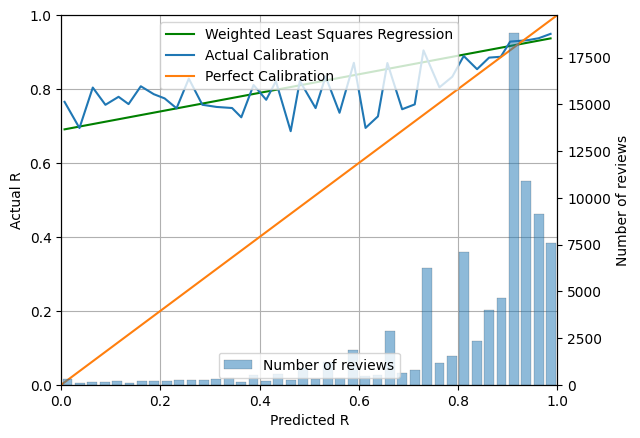

Universal Metric of FSRS: 0.0060
Universal Metric of SM2: 0.0746


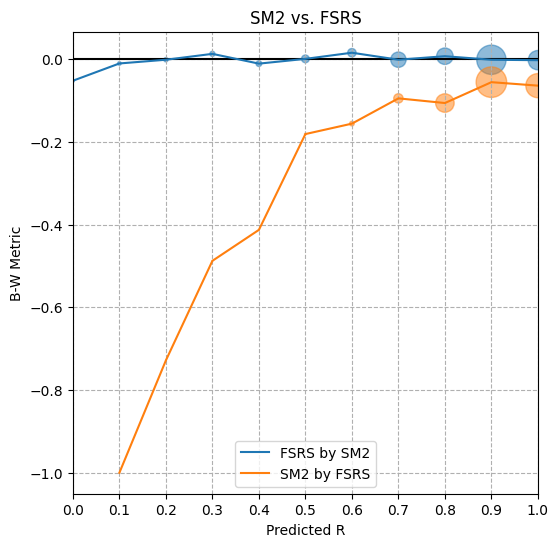

In [14]:
def sm2(history):
    ivl = 0
    ef = 2.5
    reps = 0
    for delta_t, rating in history:
        delta_t = delta_t.item()
        rating = rating.item() + 1
        if rating > 2:
            if reps == 0:
                ivl = 1
                reps = 1
            elif reps == 1:
                ivl = 6
                reps = 2
            else:
                ivl = ivl * ef
                reps += 1
        else:
            ivl = 1
            reps = 0
        ef = max(1.3, ef + (0.1 - (5 - rating) * (0.08 + (5 - rating) * 0.02)))
        ivl = max(1, round(ivl+0.01))
    return ivl

dataset['sm2_interval'] = dataset['tensor'].map(sm2)
dataset['sm2_p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['sm2_interval'])
cross_comparison = dataset[['sm2_p', 'p', 'y']].copy()

R_Metric = mean_squared_error(cross_comparison['y'], cross_comparison['sm2_p'], squared=False) - mean_squared_error(cross_comparison['y'], cross_comparison['p'], squared=False)
print("R_Metric: ", R_Metric)
plot_brier(dataset['sm2_p'], dataset['y'], bins=40)
plt.show()

plt.figure(figsize=(6, 6))

cross_comparison['SM2_B-W'] = cross_comparison['sm2_p'] - cross_comparison['y']
cross_comparison['SM2_bin'] = cross_comparison['sm2_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

plt.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM2_bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
print(f"Universal Metric of FSRS: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False):.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
plt.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
plt.plot(cross_comparison_group['FSRS_B-W', 'mean'], label='FSRS by SM2')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM2_B-W': ['mean'], 'sm2_p': ['mean', 'count']})
print(f"Universal Metric of SM2: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm2_p', 'mean'], sample_weight=cross_comparison_group['sm2_p', 'count'], squared=False):.4f}")
cross_comparison_group['sm2_p', 'percent'] = cross_comparison_group['sm2_p', 'count'] / cross_comparison_group['sm2_p', 'count'].sum()
plt.scatter(cross_comparison_group.index, cross_comparison_group['SM2_B-W', 'mean'], s=cross_comparison_group['sm2_p', 'percent'] * 1024, alpha=0.5)
plt.plot(cross_comparison_group['SM2_B-W', 'mean'], label='SM2 by FSRS')

plt.legend(loc='lower center')
plt.grid(linestyle='--')
plt.title("SM2 vs. FSRS")
plt.xlabel('Predicted R')
plt.ylabel('B-W Metric')
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()